# Lokta-Volterra model

Thesis entitled *The Metropolis-Hastings Algorithm: Inverse Problems, Model Calibration, and the TOMGRO Model*


Notebook done by **Carlos Nosa**. 




We are going to use the following packages

In [1]:
using StatsPlots
using LinearAlgebra
using Random
using Statistics
using Distributions
using Plots
using LaTeXStrings

## Forward model and data simulation

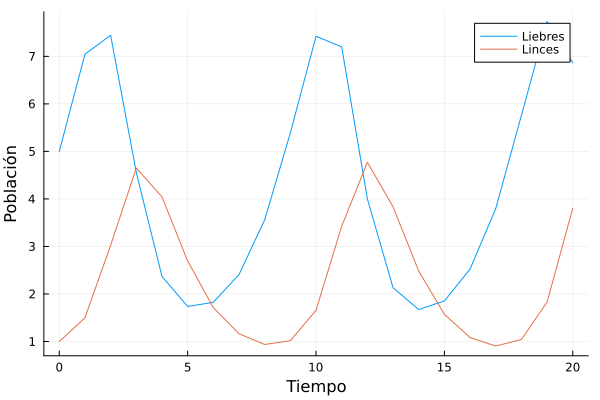

In [2]:
function lotka_volterra(du, u, p, t)
    x, y = u  # x: liebres, y: linces
    α, β, γ, δ = p  # Parámetros del modelo
    du[1] = α * x - β * x * y
    du[2] = -γ * y + δ * x * y
end

function solve_euler(f, u0, tspan, p, dt=0.01)
    t_start, t_end = tspan
    t = t_start
    u = copy(u0)
    
    t_values = Float64[]
    u_values = Vector{Float64}[]

    push!(t_values, t)
    push!(u_values, copy(u))

    du = zeros(eltype(u0), length(u0)) 

    while t < t_end
        f(du, u, p, t)   

        @. u += du * dt  
        t += dt

        push!(t_values, t)
        push!(u_values, copy(u))
    end
    t_values = t_values[1:100:end]
    u_values = hcat(u_values...)'[1:100:end,:]
    
    return t_values, u_values
end

t_values, u_values = solve_euler(lotka_volterra, [5.0, 1.0], (0.0, 20.0), [0.7, 0.3, 0.8, 0.2])

plot(t_values, u_values[:, 1], label="Liebres", xlabel="Tiempo", ylabel="Población", legend=:topright)
plot!(t_values, u_values[:, 2], label="Linces")



In [3]:
u_values

21×2 Matrix{Float64}:
 5.0      1.0
 7.04479  1.4985
 7.4431   3.02377
 4.55795  4.64923
 2.36998  4.04549
 1.73751  2.69449
 1.8257   1.71208
 2.40793  1.16344
 3.55938  0.937958
 5.38911  1.01812
 7.42244  1.65692
 7.1983   3.42634
 4.00044  4.77046
 2.13133  3.83299
 1.67298  2.482
 1.85368  1.57193
 2.52568  1.08349
 3.79698  0.9045
 5.76134  1.04382
 7.73194  1.83124
 6.86468  3.80623

In [4]:
Dinamic = zeros(21,3)
for i in 1:21
    Dinamic[i,1] = 1910 + 2*(i-1)
    Dinamic[i,2], Dinamic[i,3] = u_values[i,:]
end
Dinamic[:,2:3] = Dinamic[:,2:3] .* rand(Gamma(200,1/200),(21,2))

21×2 Matrix{Float64}:
 5.62954  0.933434
 7.23993  1.56126
 7.32945  3.07081
 4.35774  4.60758
 2.27252  3.87943
 1.69144  2.35568
 1.78073  1.64955
 2.61609  1.12123
 3.26454  0.920705
 5.21507  0.917106
 7.68874  1.6933
 7.89271  3.40236
 4.20257  4.57332
 2.10922  4.30468
 2.0174   2.51873
 1.9518   1.24327
 2.543    1.10082
 3.79414  0.982633
 4.6731   1.06047
 8.35392  1.95811
 6.97374  3.3955

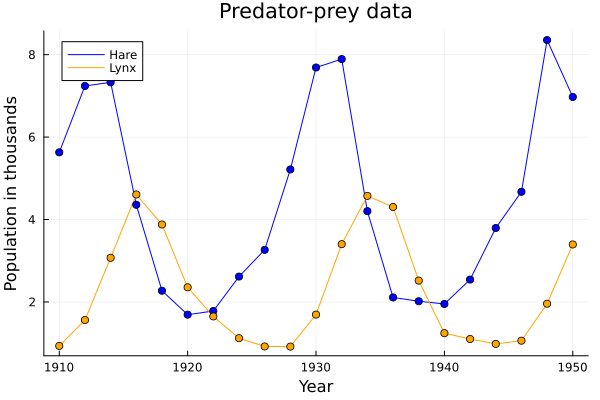

In [5]:
plot(Dinamic[:,1],Dinamic[:,2],label="Hare",title="Predator-prey data",color=:blue)
plot!(Dinamic[:,1],Dinamic[:,3],label="Lynx",color=:orange,xlabel="Year",ylabel="Population in thousands")
scatter!(Dinamic[:,1],Dinamic[:,2],label="",color=:blue)
scatter!(Dinamic[:,1],Dinamic[:,3],label="",color=:orange)

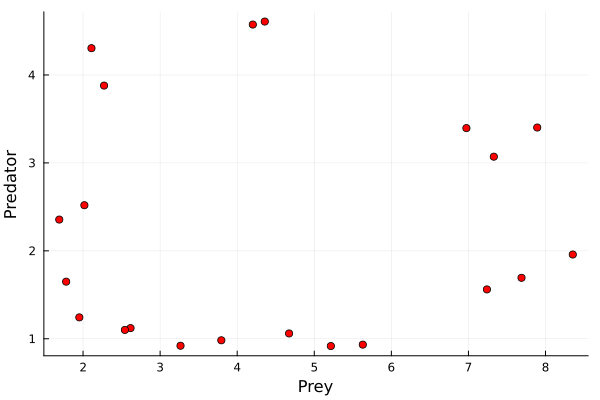

In [6]:
scatter(Dinamic[:,2],Dinamic[:,3],label="",xlabel="Prey",ylabel="Predator",color=:red)

In [7]:
function energy(p)
    α, β, γ, δ = p    
    t, λ = solve_euler(lotka_volterra, [Dinamic[1,2], Dinamic[1,3]], (0.0, 20.0), p)
    
    #Likelihood 
    likelihood = exp( mean(logpdf.(Normal.(λ,0.1), Dinamic[:,2:3] )) )

    #Prior
    prior = 1.0
    prior *= pdf(Uniform(0.0,1.0),α)
    prior *= pdf(Uniform(0.0,1.0),β)
    prior *= pdf(Uniform(0.0,1.0),γ)
    prior *= pdf(Uniform(0.0,1.0),δ)
    
    return likelihood*prior*1E1
end

energy (generic function with 1 method)

In [8]:
energy([0.7, 0.3, 0.8, 0.2])

0.012324703073280962

## Execution of MH and results

In [9]:
iterations = 10000

#Muestras del algorimo
samples = zeros(4,iterations)
#Punto de partida
## Se escoge el punto inicial
samples[:,1] = [0.5,0.5,0.5,0.5]#rand(Uniform(0,1),4)

step = 0.005

#Probabilidades
probabilities = zeros(iterations)
probabilities[1] = energy(samples[:,1])

#Tasa de aceptación
rateAlpha = 0

# Algoritmo Metrópolis-Hastings
for i in 1:iterations-1
    
    #Estado actual
    Xᵢ = samples[:,i]
    #Estado propuesto
    X₊ = rand(MvNormal(Xᵢ,step*I))
    
    #π(Estado actual → Estado propuesto)
    pXᵢX₊ = energy(X₊) * pdf(MvNormal(Xᵢ,step*I),X₊)
    #π(Estado propuesto → Estado actual)
    pX₊Xᵢ = energy(Xᵢ) * pdf(MvNormal(X₊,step*I),Xᵢ)
    #Tasa de aceptacion α
    if pX₊Xᵢ>0
        alpha = min(1, pXᵢX₊/pX₊Xᵢ)
    else
        alpha = 0.0
    end
    #Aceptación o rechazo del estado propuesto
    u = rand()    
    if u < alpha 				#Aceptación
        samples[:,i+1] = X₊
        probabilities[i+1] = energy(X₊)
        rateAlpha += 1
    else 						#Rechazo
        samples[:,i+1] = Xᵢ
        probabilities[i+1] = energy(Xᵢ)
    end
end
rateAlpha /= (iterations-1)
@show rateAlpha 
@show MAP = samples[:,findmax(probabilities)[2]]
@show CM = [mean(row) for row in eachrow(samples)]


rateAlpha = 0.0049004900490049
MAP = samples[:, (findmax(probabilities))[2]] = [0.6517729814939284, 0.29512844270130495, 0.8359547713388769, 0.20624356653545386]
CM = [mean(row) for row = eachrow(samples)] = [0.6625624979099239, 0.3044730475963048, 0.8242449050182166, 0.20065819587656994]


4-element Vector{Float64}:
 0.6625624979099239
 0.3044730475963048
 0.8242449050182166
 0.20065819587656994

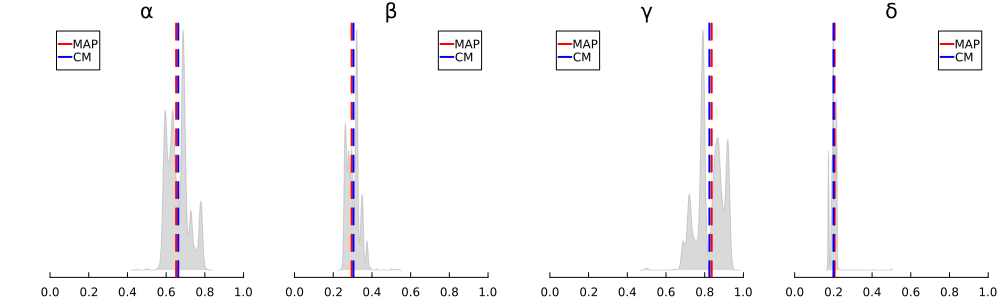

In [10]:
p1 = density(samples[1,:],label="",title="α",fill=true,alpha=0.3,color=:gray,
    xlim=(0,1),yaxis=false,legend=:topleft,grid=false)
p1 = vline!([MAP[1]], label="MAP", linestyle=:dash, color=:red,lw=2)
p1 = vline!([CM[1]], label="CM", linestyle=:dash, color=:blue,lw=2)

p2 = density(samples[2,:],label="",title="β",fill=true,alpha=0.3,color=:gray,
    xlim=(0,1),yaxis=false,legend=:topright,grid=false)
p2 = vline!([MAP[2]], label="MAP", linestyle=:dash, color=:red,lw=2)
p2 = vline!([CM[2]], label="CM", linestyle=:dash, color=:blue,lw=2)

p3 = density(samples[3,:],label="",title="γ",fill=true,alpha=0.3,color=:gray,
    xlim=(0,1),yaxis=false,legend=:topleft,grid=false)
p3 = vline!([MAP[3]], label="MAP", linestyle=:dash, color=:red,lw=2)
p3 = vline!([CM[3]], label="CM", linestyle=:dash, color=:blue,lw=2)

p4 = density(samples[4,:],label="",title="δ",fill=true,alpha=0.3,color=:gray,
    xlim=(0,1),yaxis=false,legend=:topright,grid=false)
p4 = vline!([MAP[4]], label="MAP", linestyle=:dash, color=:red,lw=2)
p4 = vline!([CM[4]], label="CM", linestyle=:dash, color=:blue,lw=2)


plot(p1,p2,p3,p4,layout=(1,4),size=(1000,300))
#savefig("5_LoktaVolterraHistograms.png")

In [11]:
samples

4×10000 Matrix{Float64}:
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  …  0.651773  0.651773  0.651773
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.295128  0.295128  0.295128
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.835955  0.835955  0.835955
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.206244  0.206244  0.206244

In [12]:
tMAP, uMAP = solve_euler(lotka_volterra, [5.0, 1.0], (0.0, 20.0), MAP)

([0.0, 1.0000000000000007, 2.0000000000000013, 2.99999999999998, 3.9999999999999587, 4.999999999999938, 5.9999999999999165, 6.999999999999895, 7.999999999999874, 8.999999999999853  …  10.99999999999981, 11.999999999999789, 12.999999999999767, 13.999999999999746, 14.999999999999725, 15.999999999999703, 16.999999999999858, 18.000000000000014, 19.00000000000017, 20.000000000000327], [5.0 1.0; 6.775062903597994 1.4621647497872747; … ; 7.232534863865188 1.6320336079886073; 6.946176085293056 3.232511821894837])

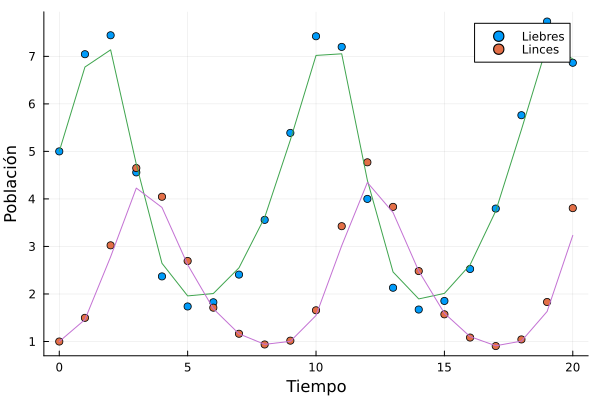

In [13]:
scatter(t_values, u_values[:, 1], label="Liebres", xlabel="Tiempo", ylabel="Población", legend=:topright)
scatter!(t_values, u_values[:, 2], label="Linces")
plot!(tMAP, uMAP[:, 1], label="", xlabel="Tiempo", ylabel="Población", legend=:topright)
plot!(tMAP, uMAP[:, 2], label="")


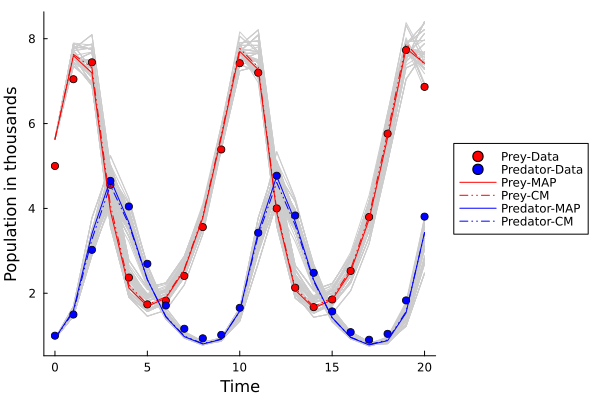

In [14]:
ts, us = solve_euler(lotka_volterra, [Dinamic[1,2], Dinamic[1,3]], (0.0, 20.0), samples[:,1000])

plotsample = plot(ts, us[:, 1], label="",color=:gray80,grid=false,
                xlabel="Time", ylabel="Population in thousands",legend=:outerright)
plotsample = plot!(ts, us[:, 2], label="",color=:gray80)


for k in 1000:100:10000
    ts, us = solve_euler(lotka_volterra, [Dinamic[1,2], Dinamic[1,3]], (0.0, 20.0), samples[:,k])
    plotsample = plot!(ts, us[:, 1], label="",color=:gray80)
    plotsample= plot!(ts, us[:, 2], label="",color=:gray80)
end

plotsample = scatter!(t_values, u_values[:, 1], label="Prey-Data",color=:red)
plotsample = scatter!(t_values, u_values[:, 2], label="Predator-Data",color=:blue)


tMAP, uMAP = solve_euler(lotka_volterra, [Dinamic[1,2], Dinamic[1,3]], (0.0, 20.0), MAP)
tCM, uCM = solve_euler(lotka_volterra, [Dinamic[1,2], Dinamic[1,3]], (0.0, 20.0), CM)


plotsample = plot!(tMAP, uMAP[:, 1], label="Prey-MAP",color=:red,linestyle=:solid)
plotsample = plot!(tCM, uCM[:, 1], label="Prey-CM",color=:red,linestyle=:dashdotdot)
plotsample = plot!(tMAP, uMAP[:, 2], label="Predator-MAP",color=:blue,linestyle=:solid)
plotsample = plot!(tCM, uCM[:, 2], label="Predator-CM",color=:blue,linestyle=:dashdotdot)

#savefig("5_LoktaVolterraDynamics_a.png")

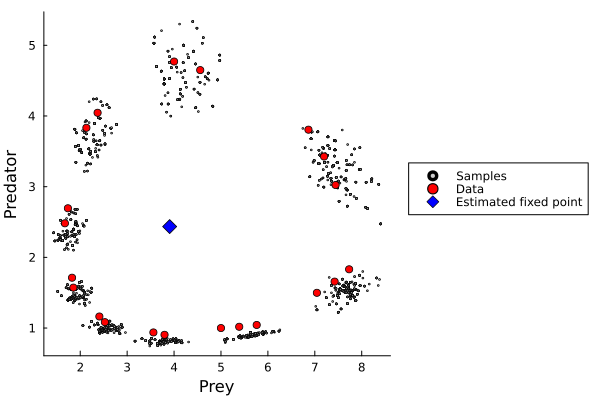

In [15]:
ts, us = solve_euler(lotka_volterra, [Dinamic[1,2], Dinamic[1,3]], (0.0, 20.0), samples[:,1000])

phasesample = scatter(us[:,1],us[:,2],label="Samples",xlabel="Prey",ylabel="Predator",
                    color=:gray80,linestyle=:dot,markersize=0.99,grid=false,legend=:outerright)


for k in 1000:50:10000
    tsk, usk = solve_euler(lotka_volterra, [Dinamic[1,2], Dinamic[1,3]], (0.0, 20.0), samples[:,k])
    phasesample = scatter!(usk[:,1],usk[:,2],label="",color=:gray80,linestyle=:dot,markersize=0.99)
end

phasesample = scatter!(u_values[:,1],u_values[:,2],label="Data",color=:red)


phasesample = scatter!([3.90621],[2.43556],label="Estimated fixed point", color=:blue,markersize=7, marker=:diamond)

#savefig("5_LoktaVolterraDynamics_b.png")

In [16]:
fixed = zeros(2,10000)
fixed[1,:]  = samples[1,:] ./ samples[2,:]
fixed[2,:]  = samples[3,:] ./ samples[4,:]
fixed

2×10000 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  2.20844  2.20844  2.20844  2.20844
 1.0  1.0  1.0  1.0  1.0  1.0  1.0     4.05324  4.05324  4.05324  4.05324

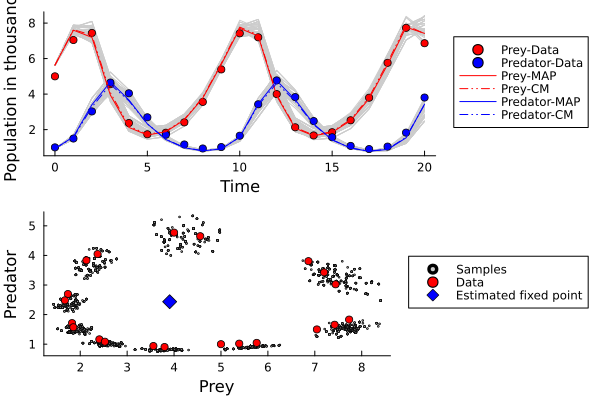

In [17]:
plot(plotsample,phasesample,layout=(2,1))
#savefig("5_LoktaVolterraDynamics.png")